# **Stock Sentiment**

## 0. Imports

In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

import gensim.downloader

os.chdir("../scripts")
from constants import TRAIN_DATA,  TEST_DATA, LABELS
from aux_funcs import preprocess, find_punctuated_tokens, eval_sklearn_model, eval_lstm_model
os.chdir("../classes")
from word2vec import Word2Vec

2025-05-31 23:54:55.006372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 23:54:55.007080: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 23:54:55.009934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 23:54:55.018034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748732095.032528   25805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748732095.03

In [2]:
# # Download NLTK resources
# nltk.download('stopwords')
# nltk.download('wordnet')

## 1. Data Loading

In [3]:
train_data = pd.read_csv(TRAIN_DATA)
test_data = pd.read_csv(TEST_DATA)

In [4]:
train_data.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [5]:
test_data.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


## 2. Data Exploration

In [6]:
# Checking for missing values
train_data.isna().sum()

text     0
label    0
dtype: int64

There are no missing values in the dataset, so it is safe to proceed.

### 2.1. Text Feature

#### 2.1.1. Word Count

Start by spliting `text` into tokens and analysing the number of tokens in each document.

In [7]:
# Fetch wordcount for each document
train_data['word_count']  = train_data['text'].apply(lambda x: len(str(x).split(" ")))
train_data[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


#### 2.1.2. Descriptive Statistics

In [8]:
train_data['word_count'].describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

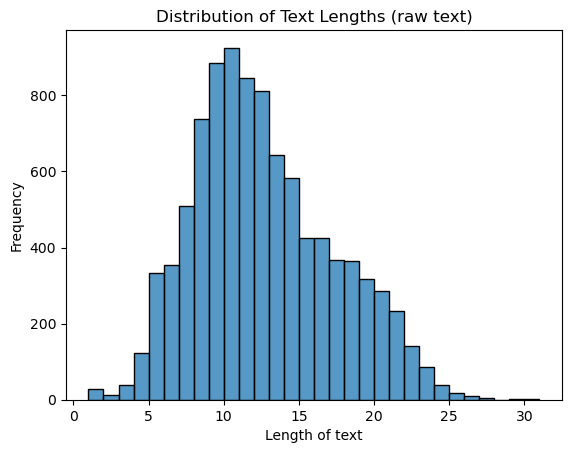

In [9]:
#Plot distribution of text length
sns.histplot(train_data['word_count'], bins=30)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

Considering the table and plot above, it is evident that some rows have very few words. Below, is a deeper exploration of these cases.

In [10]:
# Checking records with 3 words or less
train_data[train_data['word_count'] <= 3]

,text,label,word_count
1858,SASA聚酯选用英威达PTA技术,2,1
3090,Brent +4%,1,2
3593,Honeywell reaffirms guidance,2,3
3943,:),2,1
3945,@MikeCaymanTrades sometimes,2,2
...,...,...,...
8805,SBFGP,2,1
8866,took $PANW #4,2,3
8867,took $PLAY #4,2,3
8878,WBK,2,1


Looking at the records with 3 or less words, most belong to the Neutral category (label = 2). Since there is an overrepresentation of this class in the dataset, below the records above belonging to the Neutral category are excluded.

In [11]:
train_data = train_data[~((train_data['word_count'] <= 3) & (train_data['label'] == 2))]

In [12]:
# Checking word frequency
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2331
the    1820
of     1464
-      1390
in     1361
on     1134
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

From the table above, "the" and "The" are both words in the top 10 - this could indicate a beneficial effect of lowercasing the 'text' feature.<br>
Also, "-" is a very common symbol which has no meaning and should be removed from the feature.

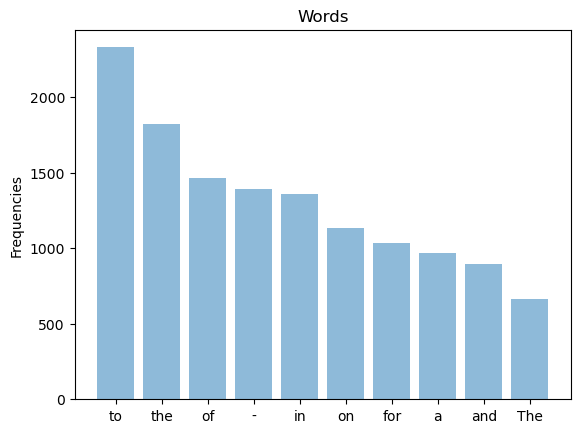

In [13]:
# Plotting the word frequencies count
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')

plt.show()

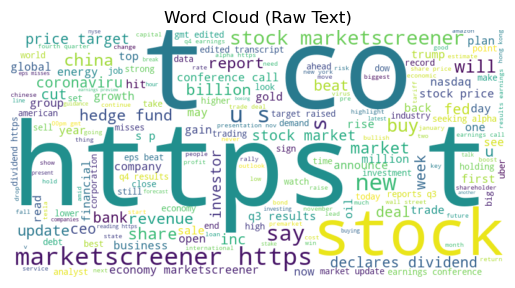

In [14]:
# Create a word cloud from the text feature
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

### 2.2. Target Feature

In [15]:
train_data['label'].value_counts()

label
2    6108
1    1923
0    1442
Name: count, dtype: int64

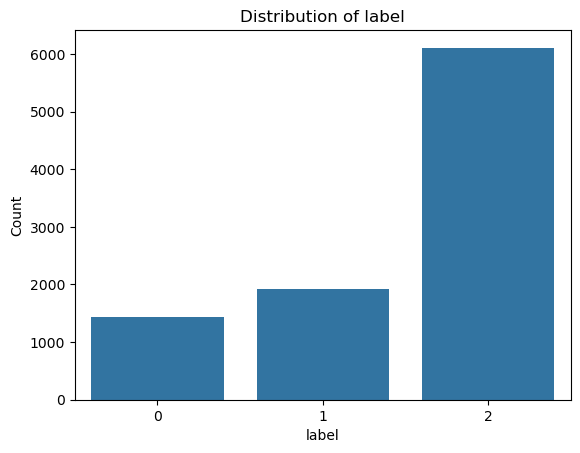

In [16]:
# Visualize distribution of label
sns.countplot(data=train_data, x='label')
plt.title("Distribution of label")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

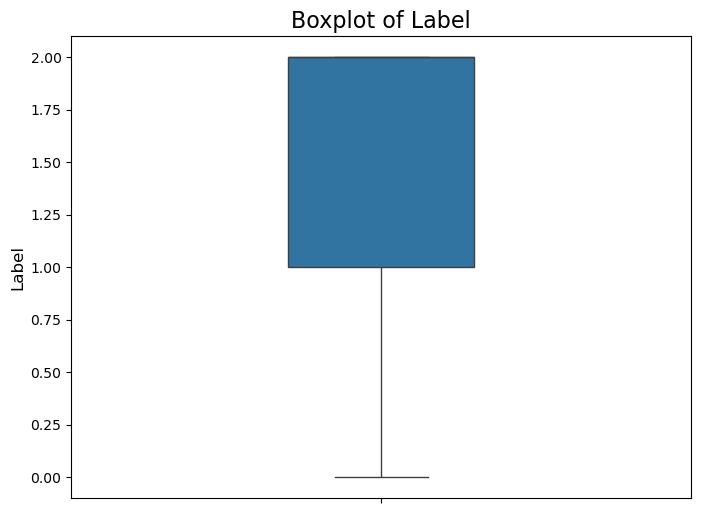

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='label', data=train_data, width=0.3)

plt.title('Boxplot of Label', fontsize=16)
plt.ylabel('Label', fontsize=12)
plt.xlabel('')

plt.show()

## 3. Data Preprocessing

In [18]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [19]:
# Defining stop words
stop = set(stopwords.words('english'))
# Initializing Lemmatizer and Stemmer
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [20]:
train_data['text'] = train_data['text'].apply(
    lambda x: preprocess(
        text=x
        ,keep_ticker=False
        ,keep_url=False
        ,stopwords=stop
        ,lemmatizer=lemma
    )
)

In [21]:
test_data['text'] = test_data['text'].apply(
    lambda x: preprocess(
        text=x
        ,keep_ticker=False
        ,keep_url=False
        ,stopwords=stop
        ,lemmatizer=lemma
    )
)

### 3.1. Rechecking the Plots

In [22]:
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

stock             1322
market             539
marketscreener     479
us                 453
new                415
report             401
say                392
price              387
result             381
earnings           349
Name: count, dtype: int64

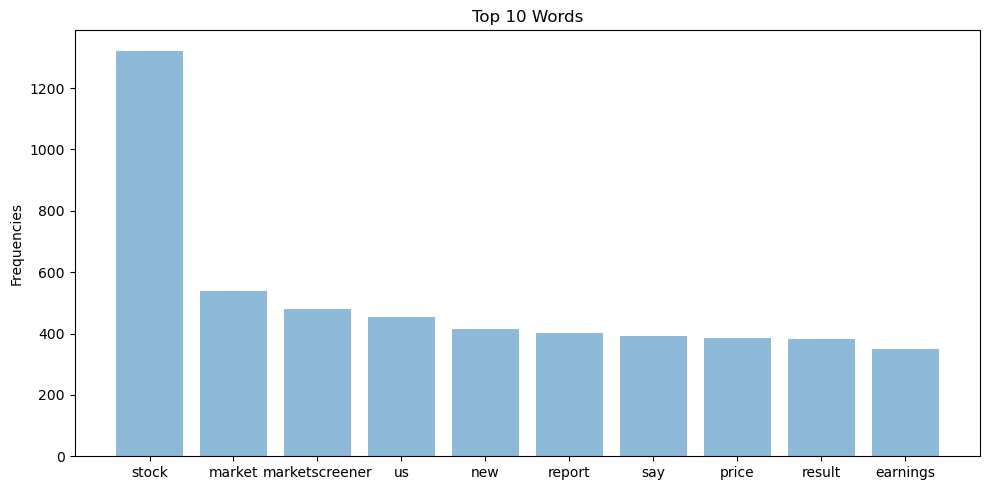

In [23]:
plt.figure(figsize=(10, 5))
x_labels = freq.index[0:10]
values = freq[:10]

plt.bar(x_labels, values, align='center', alpha=0.5)
plt.ylabel('Frequencies')
plt.title('Top 10 Words')
plt.tight_layout()

plt.show()

In [24]:
# Drop rows with encoding errors
exceptions = find_punctuated_tokens(train_data['text'])

pattern = r'(?:' + '|'.join(re.escape(word) for word in exceptions) + r')'

train_data = train_data[~train_data['text'].str.contains(pattern, case=False, na=False)]

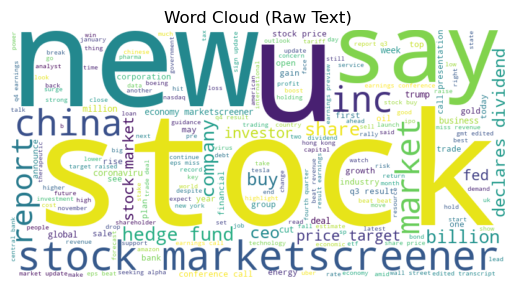

In [25]:
# Word cloud
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [ ]:
# Define dependent and independent features
# Train
X_train = train_data['text']
y_train = train_data['label']
# Test
X_test = test_data['text']

## 4. Feature Engineering

In [ ]:
# Bag of Words
bow = CountVectorizer(binary=True)  # using binary=True, because working with short text

In [ ]:
# Word2Vec
emb_size = 100
w2v_model = gensim.downloader.load(f'glove-twitter-{emb_size}')
w2v = Word2Vec(w2v_model)

In [ ]:
# Transformer (encoder)
transf = None

## 5. Modelling

In [ ]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=20)

### 5.1. KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine', weights='distance')

#### Bag of Words

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=bow
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Bag of Words)', fontsize=16)
plt.show()

#### Word2Vec

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=w2v
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Word2Vec)', fontsize=16)
plt.show()

### 5.2. LSTM

In [ ]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    vectorizer=w2v_model
    ,emb_size=emb_size
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM)', fontsize=16)
plt.show()

In [ ]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

In [ ]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.3. Transformer